In [ ]:
# TODO
- HOW IS LLAMA.CPP GRAMMAR IMPLEMENTED? - LOOKED INTO
  - it seems it zeros tokens in logit space
  - search `-INFINITY` on this file https://github.com/ggml-org/llama.cpp/blob/master/src/llama-sampling.cpp
- norm between FF and IM - DONE!
- negative mask
- fix oom
- mask per token - not collective mask for whole output - or alternatively, maybe the "more general" mask could work

- zero logits of char-by-char LLM - could try eventually?
- Was llama.cpp grammar in logit space? - yes
- Evaluate this against zeroing IN LOGIT SPACE! - no need, llama.cpp was in logit space

In [ ]:
srun -G1 --pty bash -c "source /data/ai_club/team_3_2024-25/team3-env-finetune/bin/activate; \
    hostname; \
    jupyter notebook \
        --ServerApp.root_dir=$(pwd) \
        --ServerApp.password='' \
        --ServerApp.open_browser=False \
        --ServerApp.allow_origin='*' \
        --ServerApp.allow_remote_access=True \
        --ServerApp.port=14321 \
        --ServerApp.ip='*'
"

In [1]:
import torch
import torch.nn as nn
from transformers.models.qwen2.modeling_qwen2 import Qwen2DecoderLayer
from transformers import Qwen2ForCausalLM, Qwen2Config
import transformers
from matplotlib import pyplot as plt

2025-02-19 23:00:00.893708: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 23:00:00.905864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740024000.921512 2036165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740024000.926315 2036165 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 23:00:00.941786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
w = nn.Linear(3,3)
with torch.no_grad():
    w.bias.zero_()
    w.weight.copy_(torch.eye(3))

print(all(w.bias == torch.tensor([0., 0, 0])))

print(w(torch.tensor([
    1., 2, 3
])))

torch.zeros(2)

True
tensor([1., 2., 3.], grad_fn=<ViewBackward0>)


tensor([0., 0.])

In [3]:
print(24*896*151936 * 2 * 4 / 1_000_000_000)
print(24*896*10_000 * 2 * 4 / 1_000_000_000)
# ^ 10k vocab is much better.

# solution?:
# use subset of vocab as determined by what's in training data. 
# mask can also have a "passthru" idx so remaining tokens are unaffected?

#solution2:
# use existing emb->vspace that comes with model. Share one vspace->emb across all layers
print(896*151_936 * 4 / 1_000_000_000) # size of one shared vspace->emb

26.137853952
1.72032
0.544538624


In [2]:
class IMDecoderLayer(nn.Module):
    mask = None
    vspace_to_emb = None
    emb_to_vspace = None
    post_ff_norm = None

    def __init__(self, original_layer, emb_to_vspace, config):
        super().__init__()
        self.original_layer = original_layer

        if IMDecoderLayer.mask == None:
            IMDecoderLayer.mask = torch.zeros(config.vocab_size).to('cuda')

        if IMDecoderLayer.vspace_to_emb == None:
            IMDecoderLayer.vspace_to_emb =  nn.Linear(config.vocab_size, config.hidden_size).to('cuda')
        
        if IMDecoderLayer.emb_to_vspace == None:
            IMDecoderLayer.emb_to_vspace =  emb_to_vspace

        if IMDecoderLayer.post_ff_norm == None:
            IMDecoderLayer.post_ff_norm = nn.RMSNorm(config.hidden_size).to('cuda')

    def forward(self, hidden_states, *args, **kwargs):
        hidden_states = self.original_layer(hidden_states, *args, **kwargs)
        hidden_states = hidden_states[0]

        # TODO: for inference, bypass this process on all tokens but the current one? Possible problem: maybe it will learn to rely on past tokens being allowed ones later in residual.
        # ^ maybe this process should only be done on last token if later note is a problem. If it isnt a problem, then it's preferable to do this b/c the layer will train faster.

        hidden_states = IMDecoderLayer.post_ff_norm(hidden_states)
        residual = hidden_states
        hidden_states = IMDecoderLayer.emb_to_vspace(residual)
        hidden_states *= IMDecoderLayer.mask
        hidden_states = IMDecoderLayer.vspace_to_emb(hidden_states)
        # hidden_states = (hidden_states + residual)/2 # NOTE: should also be normalization? -- avg: has to learn to recreate residual with affects added on -- add&norm: most things can be zero and only learns to affect some values
        hidden_states = hidden_states + residual # input layernorm means don't need to norm here? (and SHOULD norm after hidden state??)

        return (hidden_states,)


In [3]:
MODEL_NAME = 'Qwen/Qwen2.5-0.5B-Instruct'

config = Qwen2Config.from_pretrained(MODEL_NAME)

model = Qwen2ForCausalLM.from_pretrained(MODEL_NAME).to('cuda')

# FREEZE existing model. Only the new layer in IMDecoderLayer will be trained
for param in model.parameters():
    param.requires_grad = False

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

for i, _ in enumerate(model.model.layers):
    model.model.layers[i] = IMDecoderLayer(model.model.layers[i], model.lm_head, config)

print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x IMDecoderLayer(
        (original_layer): Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        )
      )
   

In [6]:
IMDecoderLayer.mask *= 0
# IMDecoderLayer.mask[list(set(tokenizer('bus school snow')['input_ids']))] += 1

In [7]:
tokens = tokenizer(['Here\'s my story: I took the'], return_tensors='pt', padding=True)
tokens = {k:v.to('cuda') for k,v in tokens.items()}

out = model.generate(
# out = model(
    **tokens,
    # labels=tokens['input_ids'],
    max_new_tokens=10,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.001,
    do_sample=True,
    return_dict_in_generate=True,
    output_hidden_states=True
)

# out

out_ids = out['sequences']
print(tokenizer.decode(out_ids[0]))

Here's my story: I took the story: I had the story: I took the


In [103]:
def output_w_mask(prompt, mask_toks, amt):
    IMDecoderLayer.mask *= 0
    IMDecoderLayer.mask[list(set(tokenizer(mask_toks)['input_ids']))] += amt

    out = model.generate(
        **tokens,
        max_new_tokens=10,
        pad_token_id=tokenizer.eos_token_id,
        temperature=0.001,
        do_sample=True,
        return_dict_in_generate=True,
        output_hidden_states=True
    )

    out_ids = out['sequences']
    print(tokenizer.decode(out_ids[0]))

output_w_mask('Here\'s my story: I took the', '', 0)
output_w_mask('Here\'s my story: I took the', 'bus school', 1) # school instead of work?
output_w_mask('Here\'s my story: I took the', 'bus school', 5) # More school?
output_w_mask('Here\'s my story: I took the', 'bus school snow', 1) # snow instead of rain?
output_w_mask('Here\'s my story: I took the', 'bus school snow', 10) # more
output_w_mask('Here\'s my story: I took the', 'car', 10) # car instead of bus
output_w_mask('Here\'s my story: I took the', 'car', 100) # more

# NOTE: instead of training on all tokens allowed form batch, somehow change mask per-token?. It could be the correct next token along with few other random and/or related ones.

Here's my story: I took the bus to work. The bus was crowded and it
Here's my story: I took the bus to school. It was raining, so I
Here's my story: I took the bus to school. It was a busy school day
Here's my story: I took the bus to work. It was a long journey,
Here's my story: I took the school bus to school. School school school school school
Here's my story: I took the bus to work and then walked home. It was
Here's my story: I took the longest (最长deceased) longest. longest de


## train

In [8]:
import json
from tqdm.notebook import tqdm
import gc

In [9]:
EPOCHS = 1
BATCH_SIZE = 1

In [10]:
optimizer = torch.optim.AdamW(
    [p for p in IMDecoderLayer.vspace_to_emb.parameters() if p.requires_grad]+
    [p for p in IMDecoderLayer.post_ff_norm.parameters() if p.requires_grad],
    lr=5e-5
)

In [11]:
with open('/data/ai_club/team_3_2024-25/datasets/alpaca_data_cleaned.json', 'r') as f:
    data = [x['output'] for x in json.load(f)]

dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
losses = []

for epoch in range(EPOCHS):
    i = 0
    for batch in (pbar := tqdm(dataloader)):
        try:
            optimizer.zero_grad()

            tokens = tokenizer(batch, return_tensors='pt', padding=True)
            tokens = {k:v.to('cuda') for k,v in tokens.items()}

            # set mask from batch
            IMDecoderLayer.mask *= 0
            IMDecoderLayer.mask[tokens['input_ids'].unique()] += 1
            
            outputs = model(**tokens, labels=tokens['input_ids'])
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            loss_avg = float(loss)/BATCH_SIZE
            losses.append(loss_avg)
            pbar.set_postfix(loss=loss_avg)

            if i%10 == 0:
                torch.save(IMDecoderLayer.vspace_to_emb.state_dict(), '/data/ai_club/team_3_2024-25/weights/vspace_to_emb3.pth')
                torch.save(IMDecoderLayer.post_ff_norm.state_dict(), '/data/ai_club/team_3_2024-25/weights/post_ff_norm3.pth')
        except torch.OutOfMemoryError:
            print(f'OOM on {i}')
            try: del tokens, outputs
            except NameError: pass
            gc.collect()
        i += 1

  0%|          | 0/51760 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
torch.save(IMDecoderLayer.vspace_to_emb.state_dict(), 'weights/vspace_to_emb2.pth')

In [42]:
from matplotlib import pyplot as plt
import numpy as np

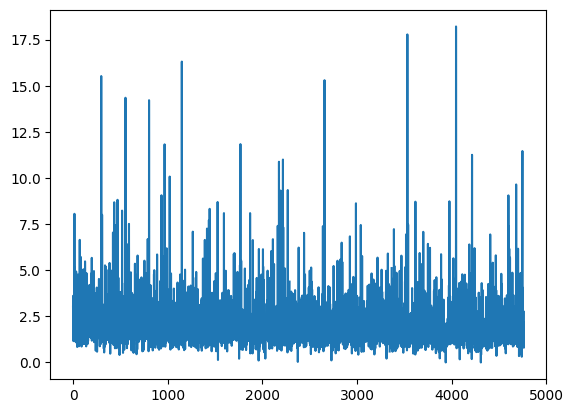

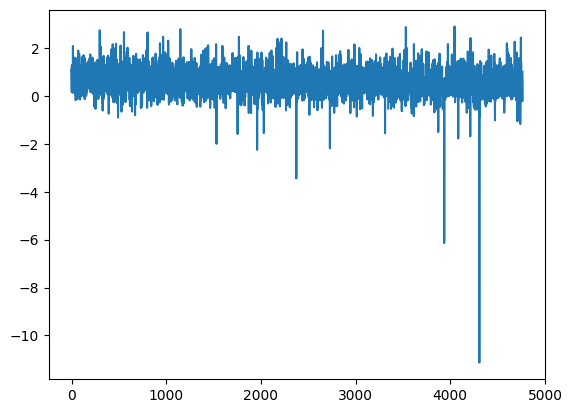

In [43]:
plt.plot(losses)
plt.show()
plt.plot(np.log(losses))

---

<div style="height: 700px"></div>

---

old:

Vocab restriction approaches
- Grammar and allowed words in context. -- Will not scale to 1000s of words. -- Might work well with a better model (something to try!!!)
- Finetune model with allowed words in context
- Finetune model with allowed current next tokens in context (?)
- Embedding Space Regularization -- add input of allowed next tok -- add term to loss that penalizes that token's embedding from getting to close to any non allowed

- without tuning -- small vocab can use first approach, but large vocab can generate one token at a time and, if one is invalid given current word, "undo" it and regenerate with added prompt "Do not use the word XYZ"
  - Say something -> I
  - Say something -> I am
  - Say something -> I am
  - Say something -> I am a teach
  - Say something -> I am a teacher <space, meaning end of word>
  - ERR: can't say "teacher"
  - Say something. Do not use the word "teacher" -> I am a
  - Say something. Do not use the word "teacher" -> I am a plumb
  - Say something. Do not use the word "teacher" -> I am a plumber
    - or go back a few if different word changes more stuff. Maybe even redo whole sentence.
  - ...
  - Say something -> I am a teacher <space, meaning end of word>
  - ERR: can't say "teacher"
  - Say something. Do not use the word "teacher" -> I am
  - Say something. Do not use the word "teacher" -> I am
  - Say something. Do not use the word "teacher" -> I am an <"an" instead of "a">
  - Say something. Do not use the word "teacher" -> I am an act
  - Say something. Do not use the word "teacher" -> I am an actor
    

In [ ]:
srun -G1 --pty bash -c "source /data/ai_club/team_3_2024-25/team3-env-finetune/bin/activate; \
    hostname; \
    jupyter notebook \
        --ServerApp.root_dir=$(pwd) \
        --ServerApp.password='' \
        --ServerApp.open_browser=False \
        --ServerApp.allow_origin='*' \
        --ServerApp.allow_remote_access=True \
        --ServerApp.port=14321 \
        --ServerApp.ip='*'
"

In [1]:
# import torch
# import torch.nn as nn
import tensorflow as tf

import transformers

2025-01-28 15:45:21.987047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 15:45:22.000926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738097122.017315 3876104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738097122.022226 3876104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 15:45:22.038486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
MODEL_NAME = 'distilbert/distilgpt2'
# MODEL_NAME = 'gpt2'

In [3]:
model = transformers.AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# class ModifiedTransformerBlock(nn.Module):
#     def __init__(self, original_layer, residual_dim):
#         super().__init__()
        
#         self.original_layer = original_layer
#         for param in self.original_layer.parameters():
#             param.requires_grad = False
        
#         self.residual_transform = nn.Linear(residual_dim, residual_dim)

#     def forward(self, hidden_states, attention_mask=None, **kwargs):
#         print(kwargs)
#         attn_output = self.original_layer.attention(hidden_states, attention_mask=attention_mask)
#         ffn_output = self.original_layer.feed_forward(attn_output)
        
#         transformed_residual = self.residual_transform(hidden_states)
#         output = ffn_output + transformed_residual
        
#         return output

# original_layer = model.transformer.h[0]
# residual_dim = original_layer.attn.c_attn.weight.size(0)

# modified_layer = ModifiedTransformerBlock(original_layer, residual_dim)

# model.transformer.h[0] = modified_layer

In [4]:
model.hidden_states

AttributeError: 'GPT2LMHeadModel' object has no attribute 'hidden_states'

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

In [6]:
tokens = tokenizer('human: hi\nbot: I AM A ROBOT\nhuman: huh?\n', return_tensors='tf')
out_ids = model.generate(**tokens, max_length=100, pad_token_id=tokenizer.eos_token_id, temperature=0.8, do_sample=True)
print(tokenizer.decode(out_ids[0]))

I0000 00:00:1738097131.399919 3876104 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


RuntimeError: Invalid device string: '/job:localhost/replica:0/task:0/device:GPU:0'